# Cycle-by-cycle analysis for resting state data
Say we ran an experiment and want to compare subjects' resting state data for some reason. Maybe we want to study age, gender, disease state, or something. This has often been done to study differences in oscillatory power or coupling between groups of people. In this notebook, we will run through how to use `bycycle` to analyze resting state data.

In this example, we have 20 subjects (10 patients, 10 control), and we for some reason hypothesized that their alpha oscillations may be systematically different. For example, (**excessive hand waving**) we think the patient group should have more top-down input that increases the synchrony in the oscillatory input (measured by its symmetry).

In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from bycycle.filt import lowpass_filter
import pandas as pd
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns=50

## Load simulated experiment of 10 patients and 10 controls

In [2]:
# Load experimental data
signals = np.load('data/sim_experiment.npy')
Fs = 1000  # Sampling rate

# Apply lowpass filter to each signal
for i in range(len(signals)):
    signals[i] = lowpass_filter(signals[i], Fs, 30, N_seconds=.2, remove_edge_artifacts=False)

(0, 10.0)

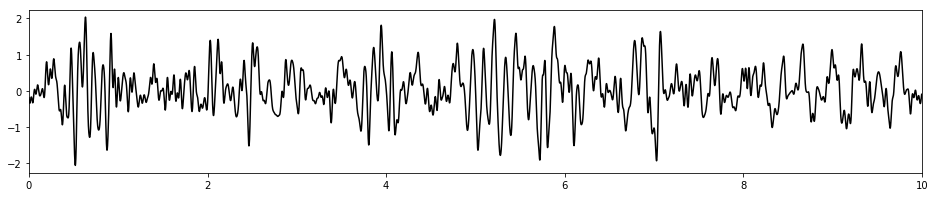

In [3]:
# Plot an example signal
N = len(signals)
T = len(signals[0])/Fs
t = np.arange(0, T, 1/Fs)

plt.figure(figsize=(16,3))
plt.plot(t, signals[0], 'k')
plt.xlim((0, T))

## Compute cycle-by-cycle features

In [4]:
from bycycle.features import compute_features

f_alpha = (7, 13) # Frequency band of interest
burst_kwargs = {'amplitude_fraction_threshold': .2,
                'amplitude_consistency_threshold': .5,
                'period_consistency_threshold': .5,
                'monotonicity_threshold': .8,
                'N_cycles_min': 3} # Tuned burst detection parameters

# Compute features for each signal and concatenate into single dataframe
dfs = []
for i in range(N):
    df = compute_features(signals[i], Fs, f_alpha,
                          burst_detection_kwargs=burst_kwargs)
    if i >= int(N/2):
        df['group'] = 'patient'
    else:
        df['group'] = 'control'
    df['subject_id'] = i
    dfs.append(df)
df_cycles = pd.concat(dfs)

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
df_cycles.head()

,sample_peak,sample_zerox_decay,sample_zerox_rise,sample_last_trough,sample_next_trough,period,time_peak,time_trough,volt_peak,volt_trough,time_decay,time_rise,volt_decay,volt_rise,volt_amp,time_rdsym,time_ptsym,band_amp,amp_fraction,amp_consistency,period_consistency,monotonicity,is_burst,group,subject_id
0,278,320,248,220,367,147,72,40,0.884764,0.170348,89,58,1.678157,0.714416,1.196286,0.394558,0.642857,0.246439,0.602151,NaN,NaN,0.802831,False,control,0
1,400,412,388,367,438,71,24,68,0.156665,-0.793393,38,33,0.901646,0.950058,0.925852,0.464789,0.260870,0.368649,0.376344,0.468359,0.482993,0.890625,False,control,0
2,472,494,457,438,519,81,37,45,1.180135,-0.744982,47,34,3.234500,1.925117,2.579808,0.419753,0.451220,0.955674,0.946237,0.468359,0.876543,1.000000,False,control,0
3,567,584,537,519,599,80,47,43,1.342554,-2.054365,32,48,1.233344,3.396919,2.315132,0.600000,0.522222,0.767799,0.881720,0.363077,0.987654,1.000000,False,control,0
4,633,652,616,599,680,81,36,32,2.034217,0.109209,47,34,3.314661,1.925008,2.619834,0.419753,0.529412,0.798461,0.956989,0.580756,0.801980,1.000000,True,control,0


### Confirm appropriateness of burst detection parameters
These burst detection parameters seem appropriate because they mostly restrict the analysis to periods of the signal that appear to be bursting. This was confirmed by looking at a few different signal segments from a few subjects.

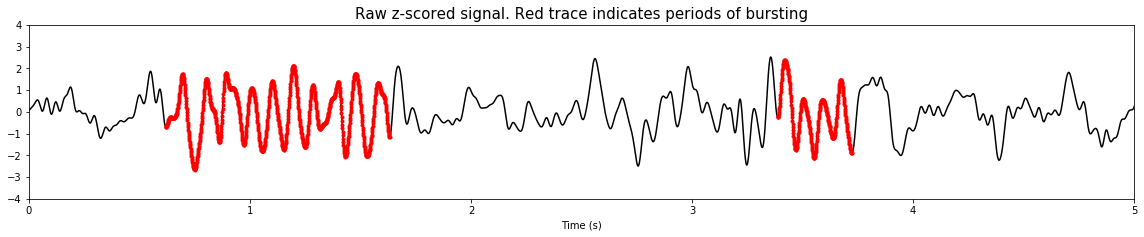

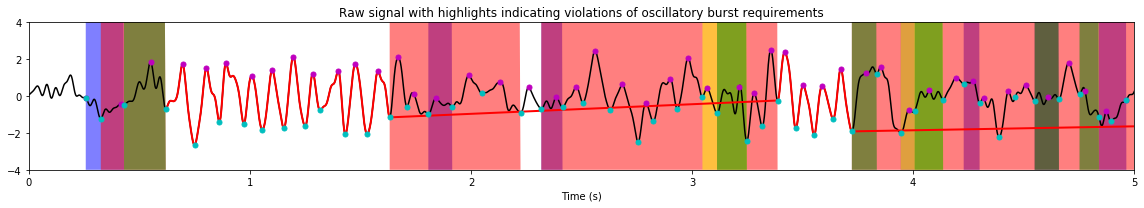

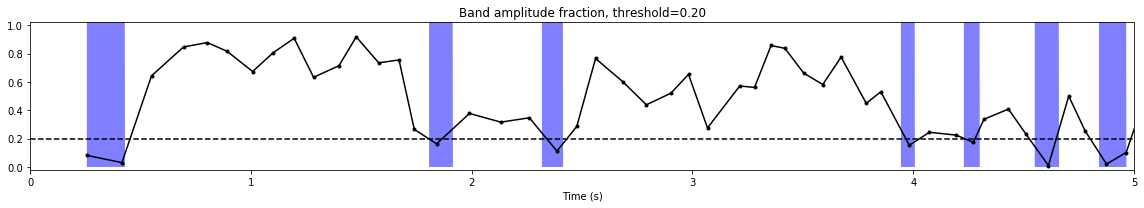

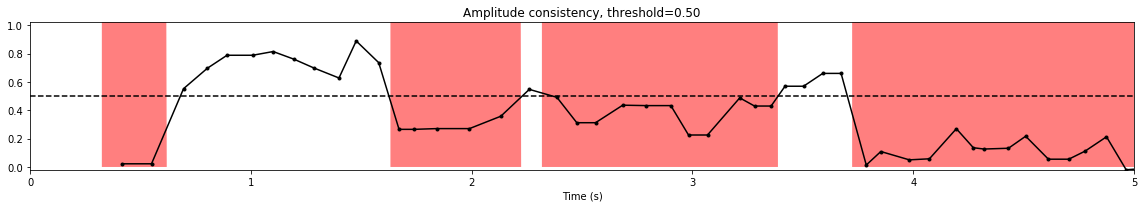

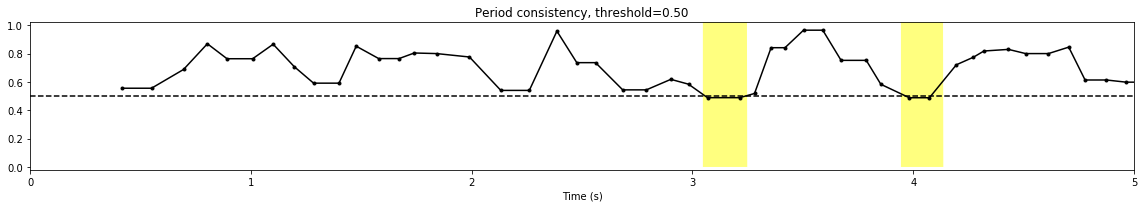

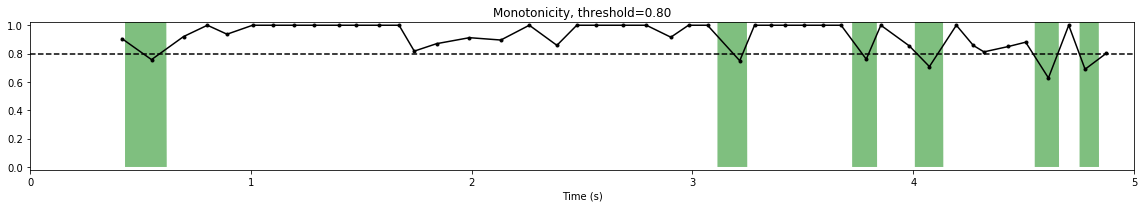

In [6]:
subj = 1
signal_df = df_cycles[df_cycles['subject_id']==subj]
from bycycle.burst import plot_burst_detect_params
plot_burst_detect_params(signals[subj], Fs, signal_df,
                         burst_kwargs, tlims=(0, 5), figsize=(16, 3), plot_only_result=True)

plot_burst_detect_params(signals[subj], Fs, signal_df,
                         burst_kwargs, tlims=(0, 5), figsize=(16, 3))

# Analyze cycle-by-cycle features
Note the significant difference between the treatment and control groups for rise-decay symmetry but not the other features

In [7]:
# Only consider cycles that were identified to be in bursting regimes
df_cycles_burst = df_cycles[df_cycles['is_burst']]

# Compute average features across subjects in a recording
features_keep = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
df_subjects = df_cycles_burst.groupby(['group', 'subject_id']).mean()[features_keep].reset_index()

In [8]:
df_subjects

,group,subject_id,volt_amp,period,time_rdsym,time_ptsym
0,control,0,1.871982,96.500000,0.508455,0.469066
1,control,1,2.343590,98.111111,0.464854,0.504368
2,control,2,2.172529,101.973684,0.521036,0.471492
3,control,3,1.753950,106.000000,0.497005,0.446969
4,control,4,2.058854,100.333333,0.467409,0.518759
5,control,5,1.741433,110.428571,0.537834,0.488439
6,control,6,2.189450,104.161290,0.516436,0.478931
7,control,7,1.931018,102.560000,0.518496,0.489314
8,control,8,1.909371,81.733333,0.513970,0.453671
9,control,9,1.955515,89.888889,0.538089,0.525733


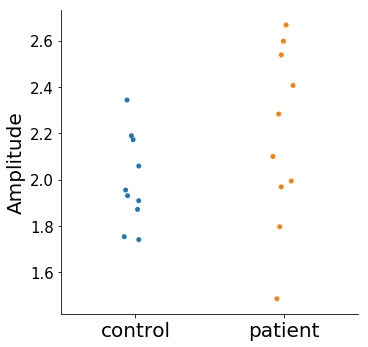

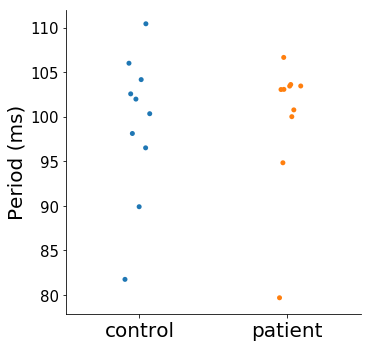

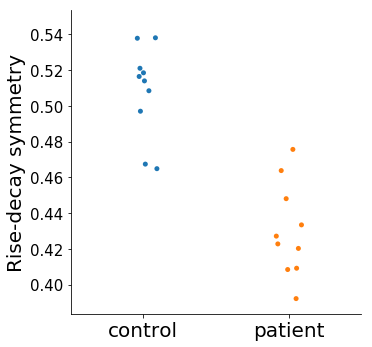

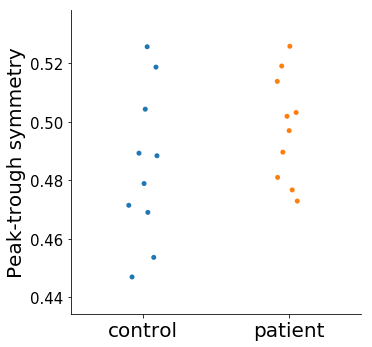

In [9]:
feature_names = {'volt_amp': 'Amplitude',
                 'period': 'Period (ms)',
                 'time_rdsym': 'Rise-decay symmetry',
                 'time_ptsym': 'Peak-trough symmetry'}
for feat, feat_name in feature_names.items():
    g = sns.catplot(x='group', y=feat, data=df_subjects)
    plt.xlabel('')
    plt.xticks(size=20)
    plt.ylabel(feat_name, size=20)
    plt.yticks(size=15);

### Statistical differences in cycle features

In [10]:
for feat, feat_name in feature_names.items():
    x_treatment = df_subjects[df_subjects['group']=='patient'][feat]
    x_control = df_subjects[df_subjects['group']=='control'][feat]
    U, p = stats.mannwhitneyu(x_treatment, x_control)
    print('{:20s} difference between groups, U= {:3.0f}, p={:.5f}'.format(feat_name, U, p))

Amplitude            difference between groups, U=  30, p=0.07023
Period (ms)          difference between groups, U=  45, p=0.36686
Rise-decay symmetry  difference between groups, U=   2, p=0.00016
Peak-trough symmetry difference between groups, U=  32, p=0.09294
